In [1]:
# Célula 1 - Importação de bibliotecas para a Questão 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, measure
from sklearn.cluster import KMeans
import os
from google.colab import files

In [2]:
# Célula 2 - Criar estrutura de pastas
!mkdir -p /content/img
print("Pasta 'img' criada!")

Pasta 'img' criada!


In [3]:
# Célula 3 - Upload da imagem
uploaded = files.upload()

# Mover a imagem para a pasta img
for filename in uploaded.keys():
    !mv "{filename}" "/content/img/{filename}"
    print(f"Imagem {filename} movida para /content/img/")

Saving imagem_medica.jpg to imagem_medica.jpg
Imagem imagem_medica.jpg movida para /content/img/


In [4]:
# Célula 4 - Verificar se a imagem está na pasta
!ls /content/img/

imagem_medica.jpg


In [5]:
# Célula 5 - Carregar e processar a imagem médica com K-means (mesma imagem da Questão 1)
# Esta etapa isola a região de interesse para posterior esqueletização
def carregar_e_segmentar_imagem_medica():
    """
    Carrega a imagem médica e aplica segmentação K-means
    """
    imagem_path = "/content/img/imagem_medica.jpg"

    # Verificar se a imagem existe
    if not os.path.exists(imagem_path):
        raise FileNotFoundError(f"Imagem não encontrada: {imagem_path}")

    # Carregar imagem colorida
    img = cv2.imread(imagem_path)
    if img is None:
        raise ValueError(f"Erro ao carregar imagem: {imagem_path}")

    # Converter BGR para RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Redimensionar para aplicação do K-means (método da Questão 1)
    pixel_values = img_rgb.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Aplicar K-means ()
    k = 4
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image = segmented_data.reshape(img_rgb.shape)

    return img_rgb, segmented_image, labels.reshape(img_rgb.shape[:2])

# Carregar e segmentar a imagem
img_original, img_kmeans, labels_map = carregar_e_segmentar_imagem_medica()

print("Imagem médica segmentada com K-means!")

Imagem médica segmentada com K-means!


In [ ]:
# Célula 6 - Selecionar região de interesse e pré-processar (CORRIGIDA)
def selecionar_maior_regiao(mascara):
    """
    Seleciona a maior região conectada da máscara
    """
    # Encontrar componentes conectados
    labels = measure.label(mascara)
    regions = measure.regionprops(labels)

    if len(regions) == 0:
        return None

    # Encontrar a região com maior área
    maior_regiao = max(regions, key=lambda x: x.area)

    # Criar máscara apenas com a maior região
    mascara_maior = np.zeros_like(mascara, dtype=np.uint8)
    mascara_maior[labels == maior_regiao.label] = 1

    return mascara_maior

def preprocessar_para_esqueleto(img_kmeans, labels_map):
    """
    Pré-processa a imagem segmentada para extração do esqueleto
    """
    # Selecionar o cluster com maior área (geralmente o objeto principal)
    clusters_unicos, contagens = np.unique(labels_map, return_counts=True)
    # Encontrar o cluster com maior área (ignorando possíveis ruídos pequenos)
    cluster_principal = clusters_unicos[np.argmax(contagens)]

    # Criar máscara binária
    mascara = (labels_map == cluster_principal).astype(np.uint8)

    # Selecionar apenas a maior região conectada
    mascara_maior = selecionar_maior_regiao(mascara)

    if mascara_maior is None:
        print("Nenhuma região encontrada! Usando máscara completa.")
        mascara_maior = mascara

    # Verificar se a maioria dos pixels é o objeto (branco) ou fundo (preto)
    if np.sum(mascara_maior) > (mascara_maior.size - np.sum(mascara_maior)):
        # Se há mais pixels brancos que pretos, inverter a máscara
        mascara_maior = 1 - mascara_maior
        print("Máscara invertida para corrigir objeto/fundo")

    # Aplicar operações morfológicas para suavizar a máscara
    kernel = np.ones((5,5), np.uint8)
    mascara_suavizada = cv2.morphologyEx(mascara_maior, cv2.MORPH_CLOSE, kernel)
    mascara_suavizada = cv2.morphologyEx(mascara_suavizada, cv2.MORPH_OPEN, kernel)

    return mascara_suavizada, mascara_maior

# Pré-processar a imagem segmentada
mascara_suavizada, mascara_original = preprocessar_para_esqueleto(img_kmeans, labels_map)

print("Máscara da região principal preparada para esqueletização!")

Máscara invertida para corrigir objeto/fundo
Máscara da região principal preparada para esqueletização!


In [7]:
# Célula 7 - Implementação da Esqueletização
# Representação geométrica via morfologia matemática
# O esqueleto captura a estrutura topológica central do objeto

# Técnica: Morfologia matemática via erosões sucessivas
def extrair_esqueleto(mascara_binaria):
    """
    Extrai o esqueleto de uma máscara binária usando morfologia matemática
    """
    # Converter para boolean (requisito do skimage)
    mascara_bool = mascara_binaria.astype(bool)

    # Aplicar esqueletização
    esqueleto = morphology.skeletonize(mascara_bool)

    return esqueleto

def encontrar_pontos_caracteristicos(esqueleto):
    """
    Encontra pontos característicos no esqueleto
    """
    # Encontrar pontos de ramificação e terminação
    esqueleto_uint8 = esqueleto.astype(np.uint8)

    pontos_ramificacao = []
    pontos_terminacao = []

    # Análise simplificada - pontos com 1 vizinho (terminação) ou 3+ vizinhos (ramificação)
    for coord in np.argwhere(esqueleto):
        y, x = coord
        vizinhos = 0

        # Contar vizinhos (conectividade 8)
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dy == 0 and dx == 0:
                    continue
                ny, nx = y + dy, x + dx
                if (0 <= ny < esqueleto.shape[0] and 0 <= nx < esqueleto.shape[1]
                    and esqueleto[ny, nx]):
                    vizinhos += 1

        if vizinhos == 1:
            pontos_terminacao.append((x, y))
        elif vizinhos >= 3:
            pontos_ramificacao.append((x, y))

    return pontos_terminacao, pontos_ramificacao

# Extrair esqueleto da máscara
esqueleto = extrair_esqueleto(mascara_suavizada)

# Encontrar pontos característicos
pontos_terminacao, pontos_ramificacao = encontrar_pontos_caracteristicos(esqueleto)

print(f"Esqueleto extraído com sucesso!")
print(f"Pontos de terminação encontrados: {len(pontos_terminacao)}")
print(f"Pontos de ramificação encontrados: {len(pontos_ramificacao)}")

Esqueleto extraído com sucesso!
Pontos de terminação encontrados: 33
Pontos de ramificação encontrados: 198


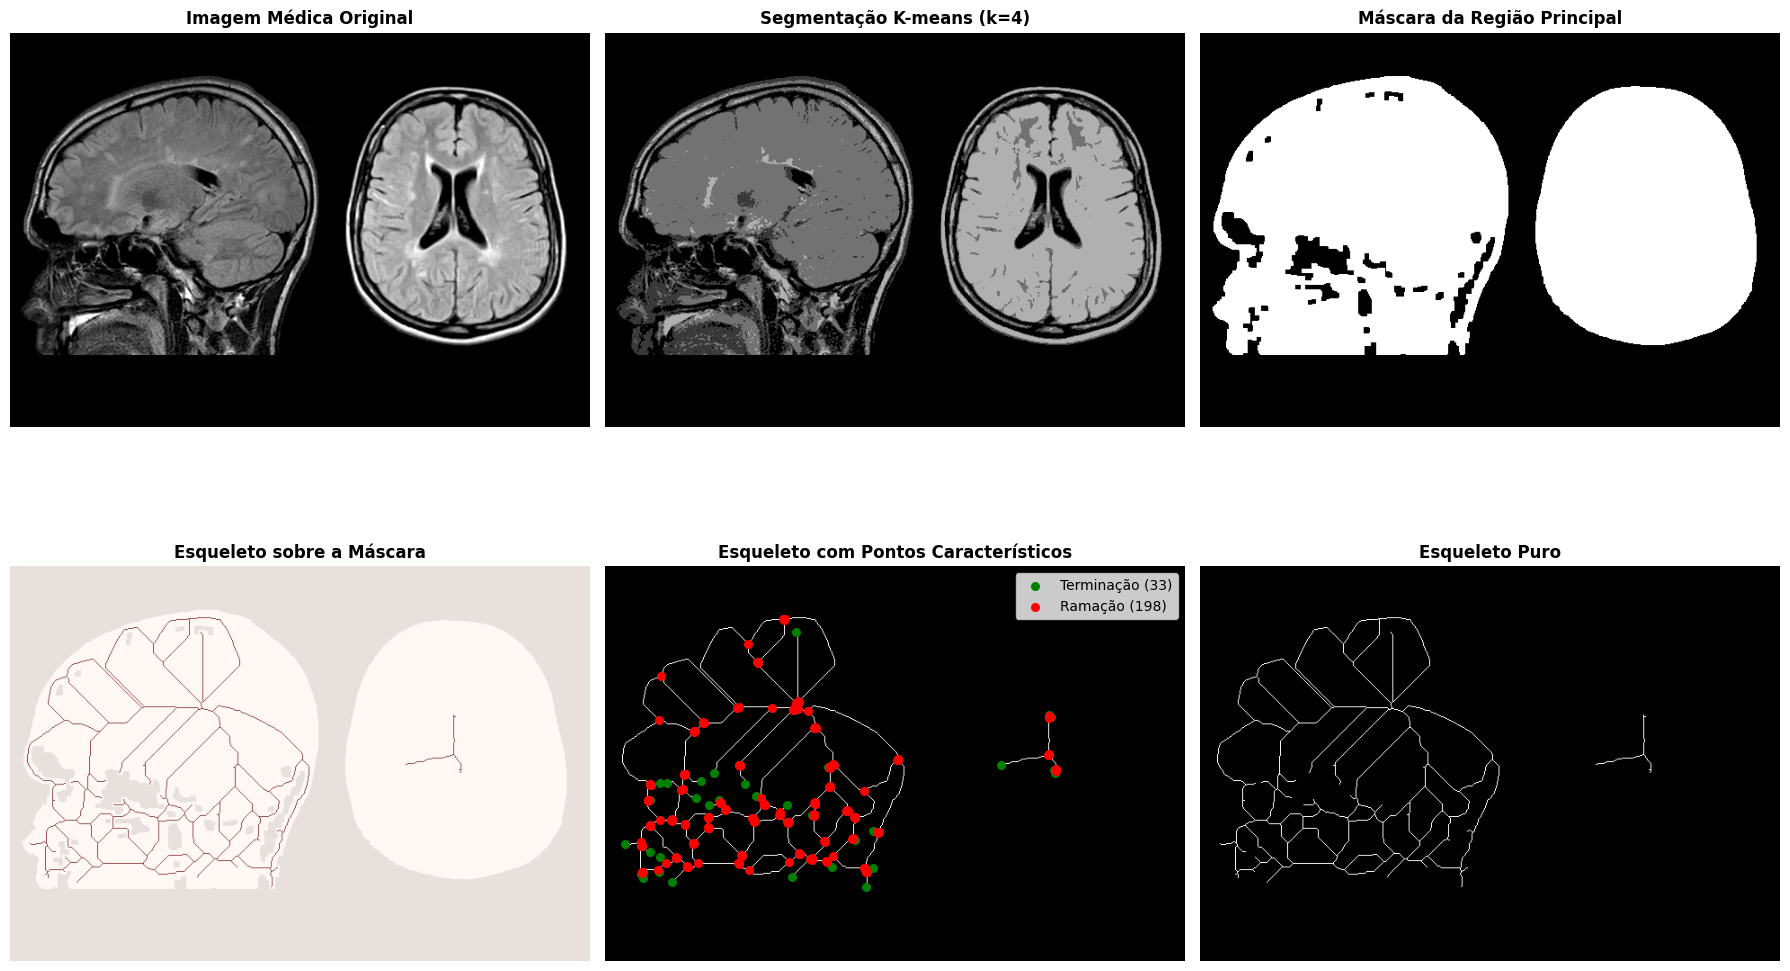

In [8]:
# Célula 8 - Visualização dos resultados
def visualizar_resultados_esqueletizacao(img_original, img_kmeans, mascara, esqueleto,
                                       pontos_terminacao, pontos_ramificacao):
    """
    Visualiza todos os passos da esqueletização
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Imagem original
    axes[0,0].imshow(img_original)
    axes[0,0].set_title('Imagem Médica Original', fontsize=12, fontweight='bold')
    axes[0,0].axis('off')

    # Imagem segmentada com K-means
    axes[0,1].imshow(img_kmeans)
    axes[0,1].set_title('Segmentação K-means (k=4)', fontsize=12, fontweight='bold')
    axes[0,1].axis('off')

    # Máscara binária da região principal
    axes[0,2].imshow(mascara, cmap='gray')
    axes[0,2].set_title('Máscara da Região Principal', fontsize=12, fontweight='bold')
    axes[0,2].axis('off')

    # Esqueleto sobre a máscara
    axes[1,0].imshow(mascara, cmap='gray', alpha=0.3)
    axes[1,0].imshow(esqueleto, cmap='Reds', alpha=0.7)
    axes[1,0].set_title('Esqueleto sobre a Máscara', fontsize=12, fontweight='bold')
    axes[1,0].axis('off')

    # Esqueleto com pontos característicos
    axes[1,1].imshow(esqueleto, cmap='gray')

    # Plotar pontos de terminação (verde)
    if pontos_terminacao:
        term_x, term_y = zip(*pontos_terminacao)
        axes[1,1].scatter(term_x, term_y, c='green', s=30, label=f'Terminação ({len(pontos_terminacao)})')

    # Plotar pontos de ramificação (vermelho)
    if pontos_ramificacao:
        ram_x, ram_y = zip(*pontos_ramificacao)
        axes[1,1].scatter(ram_x, ram_y, c='red', s=30, label=f'Ramação ({len(pontos_ramificacao)})')

    axes[1,1].set_title('Esqueleto com Pontos Característicos', fontsize=12, fontweight='bold')
    axes[1,1].legend()
    axes[1,1].axis('off')

    # Apenas esqueleto
    axes[1,2].imshow(esqueleto, cmap='gray')
    axes[1,2].set_title('Esqueleto Puro', fontsize=12, fontweight='bold')
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar resultados
visualizar_resultados_esqueletizacao(img_original, img_kmeans, mascara_suavizada,
                                   esqueleto, pontos_terminacao, pontos_ramificacao)

In [9]:
# Célula 9 - Análise quantitativa e métricas do esqueleto
def analisar_esqueleto(esqueleto, mascara_original):
    """
    Calcula métricas quantitativas do esqueleto
    """
    # Estatísticas básicas
    area_original = np.sum(mascara_original)
    area_esqueleto = np.sum(esqueleto)
    razao_reducao = area_esqueleto / area_original if area_original > 0 else 0

    # Comprimento do esqueleto (número de pixels)
    comprimento = area_esqueleto

    # Encontrar componentes conectados no esqueleto
    labels_skel = measure.label(esqueleto, connectivity=2)
    num_componentes = len(np.unique(labels_skel)) - 1  # Excluir fundo

    print("="*50)
    print("ANÁLISE QUANTITATIVA DO ESQUELETO")
    print("="*50)
    print(f"Área da região original: {area_original} pixels")
    print(f"Área do esqueleto: {area_esqueleto} pixels")
    print(f"Razão de redução: {razao_reducao:.4f} ({razao_reducao*100:.2f}%)")
    print(f"Comprimento do esqueleto: {comprimento} pixels")
    print(f"Número de componentes conectados: {num_componentes}")
    print(f"Pontos de terminação: {len(pontos_terminacao)}")
    print(f"Pontos de ramificação: {len(pontos_ramificacao)}")
    print("="*50)

    return {
        'area_original': area_original,
        'area_esqueleto': area_esqueleto,
        'razao_reducao': razao_reducao,
        'comprimento': comprimento,
        'num_componentes': num_componentes,
        'pontos_terminacao': len(pontos_terminacao),
        'pontos_ramificacao': len(pontos_ramificacao)
    }

# Realizar análise quantitativa
metricas = analisar_esqueleto(esqueleto, mascara_suavizada)

ANÁLISE QUANTITATIVA DO ESQUELETO
Área da região original: 135569 pixels
Área do esqueleto: 3123 pixels
Razão de redução: 0.0230 (2.30%)
Comprimento do esqueleto: 3123 pixels
Número de componentes conectados: 2
Pontos de terminação: 33
Pontos de ramificação: 198
